# Example 6: Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis, or LDA, is a statistical method used in the field of machine learning and pattern recognition for both dimensionality reduction and classification. It focuses on finding a linear combination of features that best separate two or more classes of events or objects. 

## Key Concepts

- **Objective**: LDA seeks to reduce dimensions while preserving as much of the class discriminatory information as possible.
- **Approach**: It projects the data onto a lower-dimensional space where the separation between the different classes is maximized.
- **Assumptions**: Assumes that the data is normally distributed, the classes have identical covariance matrices, and the means of the distributions are different.

As you will see, we chose to code this example explicitly in order to graph important elements, such as the decision boundary. The truth about LDA is that it is not that common to use in the professional world. Still, this is a missed opportunity. LDA performs well in scenarios where assumptions about normally distributed classes and identical class covariances hold true. It allows high dimensional data to be projected down to a much lower dimensional space using explicit and easy to compute formulas.  

In [1]:
# Standard imports 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Dataset
from sklearn.datasets import load_iris

# For modeling 
from sklearn import linear_model, datasets
import itertools

# For graphing
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

# For Evaluation
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Because we wish to compute several aspects not well supported by well-known packages such as Scikit-Learn, we will code this explicitly. Whenever we need to code something explicitly, we will organize that code into existing functions.  

Although the iris dataset is a famous example to use for LDA, much of the credit of the code below belongs to the following site and its creators. The code is borrowed heavily from their work. 

https://xavierbourretsicotte.github.io/LDA_QDA.html

The code follows along with the mathematics done in class as well as discussed in the book.

In [2]:
def multivariate_gaussian_pdf(X, MU, SIGMA):
    """
    Calculate the probability density of a multivariate Gaussian distribution.

    Parameters:
    X (ndarray): A numpy array representing the point at which the probability density is evaluated.
    MU (ndarray): A numpy array representing the mean vector of the Gaussian distribution.
    SIGMA (ndarray): A numpy array representing the covariance matrix of the Gaussian distribution.

    Returns:
    float: The probability density of the multivariate Gaussian distribution at point X.
    """

    # Reshape X and MU to ensure they are column vectors.
    X = X.reshape(-1, 1)
    MU = MU.reshape(-1, 1)

    # Get the dimension of the Gaussian distribution.
    p, _ = SIGMA.shape

    # Compute the inverse of the covariance matrix.
    SIGMA_inv = np.linalg.inv(SIGMA)

    # Calculate the Gaussian probability density function.
    denominator = np.sqrt((2 * np.pi)**p * np.linalg.det(SIGMA))
    exponent = -(1/2) * ((X - MU).T @ SIGMA_inv @ (X - MU))

    # Extract the scalar value from the 1x1 matrix to avoid deprecation warning
    exponent_scalar = exponent[0, 0]
    
    return float((1. / denominator) * np.exp(exponent_scalar))


def calculate_boundary(X, MU_k, MU_l, SIGMA, pi_k, pi_l):
    """
    Calculate the decision boundary for a binary classifier based on the Gaussian distribution.

    Parameters:
    X (ndarray): A numpy array representing the data point at which the decision boundary is evaluated.
    MU_k (ndarray): The mean vector of the Gaussian distribution for class k.
    MU_l (ndarray): The mean vector of the Gaussian distribution for class l.
    SIGMA (ndarray): The shared covariance matrix for the Gaussian distributions.
    pi_k (float): The prior probability of class k.
    pi_l (float): The prior probability of class l.

    Returns:
    float: The value of the decision boundary function at point X.
    """

    # Calculate the inverse of the covariance matrix.
    SIGMA_inv = np.linalg.inv(SIGMA)

    # Compute the terms for the log of the ratio of the prior probabilities.
    log_prior_ratio = np.log(pi_k / pi_l)
    means_term = -1/2 * (MU_k + MU_l).T @ SIGMA_inv @ (MU_k - MU_l)
    x_term = X.T @ SIGMA_inv @ (MU_k - MU_l)

    # Sum the terms and flatten the result to get a scalar value.
    decision_value = (log_prior_ratio + means_term + x_term).flatten()[0]

    return decision_value


def LDA_score(X, MU_k, SIGMA, pi_k):
    """
    Compute the Linear Discriminant Analysis (LDA) score for a specific class and data point.

    Parameters:
    X (ndarray): A numpy array representing the data point for which the LDA score is calculated.
    MU_k (ndarray): The mean vector for class k.
    SIGMA (ndarray): The covariance matrix, assumed to be the same for all classes in LDA.
    pi_k (float): The prior probability of class k.

    Returns:
    float: The LDA score for class k given the data point X.
    """

    # Compute the inverse of the covariance matrix
    SIGMA_inv = np.linalg.inv(SIGMA)

    # Log of the prior probability for class k
    log_prior = np.log(pi_k)

    # The LDA score
    quadratic_term = -1/2 * (MU_k).T @ SIGMA_inv @ MU_k
    linear_term = X.T @ SIGMA_inv @ MU_k
    lda_score = (log_prior + quadratic_term + linear_term).flatten()[0]

    return lda_score


def predict_LDA_class(X, MU_list, SIGMA, pi_list):
    """
    Predict the class label for a data point using Linear Discriminant Analysis (LDA).

    Parameters:
    X (ndarray): A numpy array representing the data point to be classified.
    MU_list (list of ndarray): A list of mean vectors, one for each class.
    SIGMA (ndarray): The shared covariance matrix used in LDA.
    pi_list (list): A list of prior probabilities, one for each class.

    Returns:
    int: The predicted class label for the data point X, identified by the highest LDA score.
    """

    scores_list = []
    classes = len(MU_list)

    # Compute the LDA score for each class and append it to the scores list
    for p in range(classes):
        score = LDA_score(X.reshape(-1,1), MU_list[p].reshape(-1,1), SIGMA, pi_list[p])
        scores_list.append(score)

    # Return the index of the class with the highest score
    # This index corresponds to the predicted class label
    return np.argmax(scores_list)

The Iris dataset is a classic dataset widely used in statistics and machine learning for educational purposes. It is commonly used for classification tasks and we will use it several times in our examples. 

### Dataset Composition

- **Total Observations**: 150 (50 samples from each of the three species)
- **Features (Measured in Centimeters)**:
  1. `Sepal Length`: Length of the sepal (the outer parts of the flower).
  2. `Sepal Width`: Width of the sepal.
  3. `Petal Length`: Length of the petal (the inner part of the flower).
  4. `Petal Width`: Width of the petal.

### Labels

Each sample in the dataset is labeled with the species of the Iris plant:
1. `Iris setosa`,
2. `Iris virginica`, and
3. `Iris versicolor`.


In [3]:
# Load the Iris dataset
iris = load_iris()

# Create a DataFrame from the Iris dataset
iris_data = pd.DataFrame(iris.data, columns=iris.feature_names)

# Add a 'species' column to the DataFrame with the target labels
iris_data['species'] = iris.target_names[iris.target]

# Prepare the feature matrix (X) and the target vector (y)
X = iris_data.drop('species', axis=1)
Y = iris_data['species']

# Perform a train-test split
# This example uses 70% of the data for training and 30% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=6)

# Data frames constructed for training 
data = pd.concat([X_train, Y_train], axis=1)
data_test = pd.concat([X_test, Y_test.reset_index(drop=True)], axis=1)

Restricting to only two dimensions, sepal length and sepal width, allows us to plot the classes.

Seaborn's `pairplot` is a function used to visualize the relationships between pairs of features in a dataset, which is useful when studying higher dimensional data. 

The off-diagonal plots are two-dimensional projections of the data. This is why one can observe a symmetry between these elements. The diagonal elements show the histograms that represent the frequency of each category according to the specified value. One observation that we can make is that petal length and petal width better separate the categories than sepal length and sepal width. 

/Users/ysingh/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


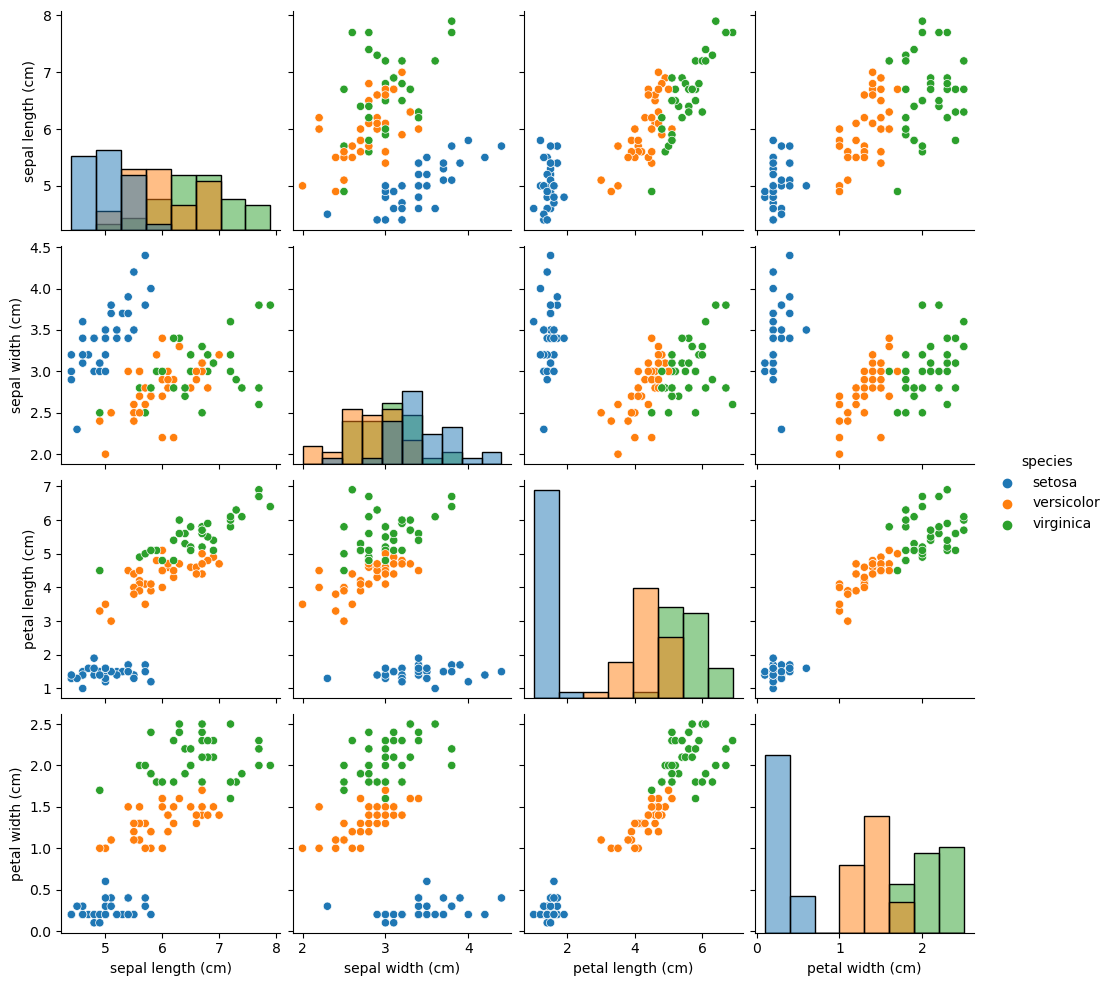

In [4]:
sns.pairplot(data, hue="species", diag_kind='hist')

Based on the above features, we may pick a particular projection to study closely and perform LDA. Remember, we do not need to do this projection mathematically. We only do it here so we can plot and visualize the classification fully. 

In [5]:
# Select which variables to study closely
j = 1
k = 2
print(iris.feature_names[j], iris.feature_names[k])

sepal width (cm) petal length (cm)


Based on the choice above, let's display the scatter plot more closely. 

/Users/ysingh/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Scatter plot of Training Data by Species')

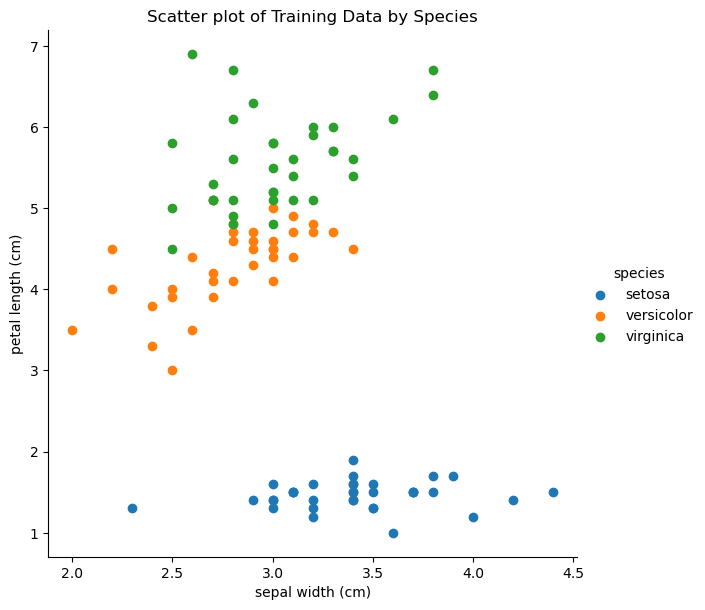

In [6]:
facet_grid = sns.FacetGrid(data, height=6, hue="species")
facet_grid.map(plt.scatter, iris.feature_names[j], iris.feature_names[k])
facet_grid.add_legend()
plt.title(f'Scatter plot of Training Data by Species')

We now perform LDA on the dataset and graph the results. 

/Users/ysingh/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


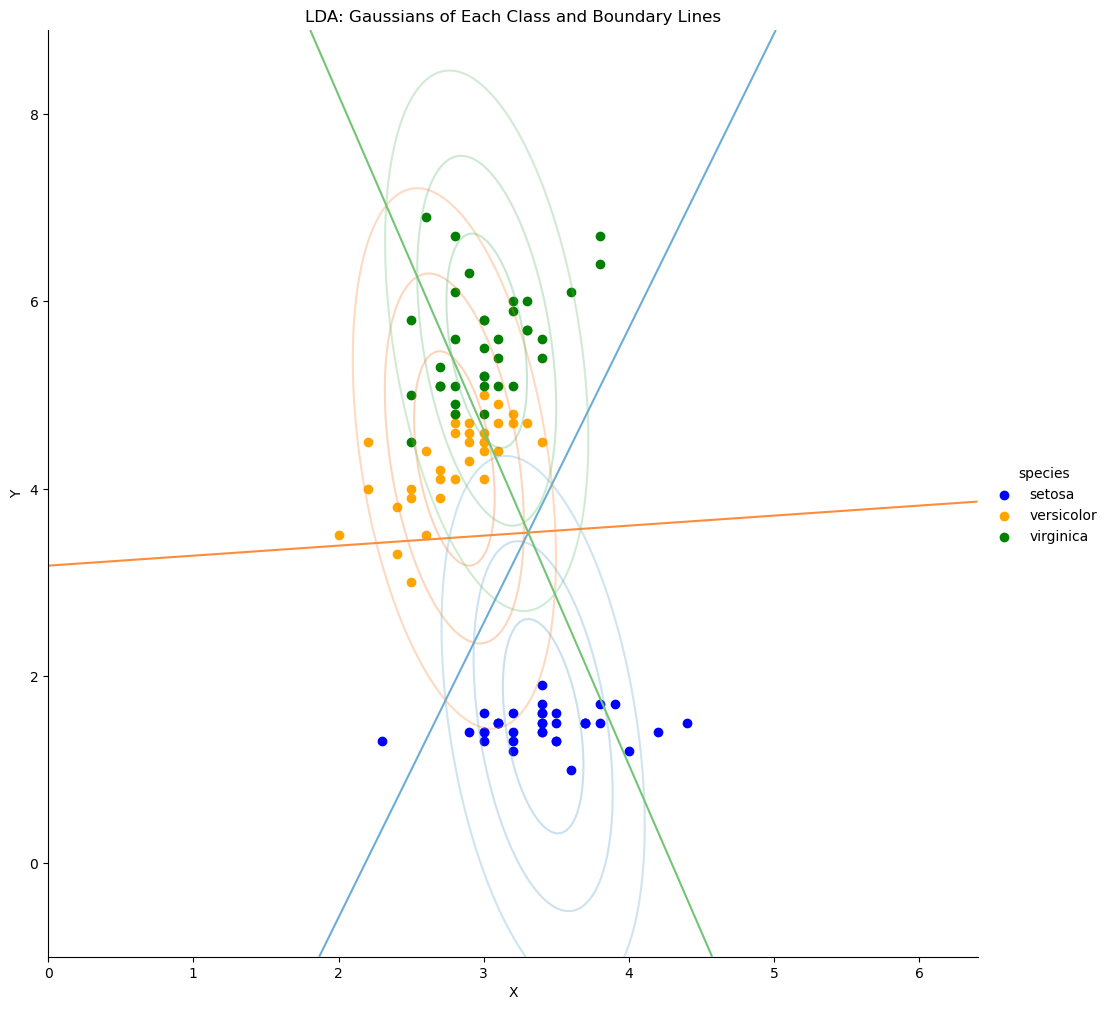

In [7]:
# Extract a subset of the data focusing on the chosen dimensions and species
df1 = data[[iris.feature_names[j], iris.feature_names[k], 'species']]

# ----- Estimating the parameters for LDA -------

# Mean values for each species into separate arrays
mu_list = np.split(df1.groupby('species').mean().values, [1, 2])

# The covariance matrix
sigma = df1.iloc[:, :2].cov().values

# Calculate the prior probabilities for each species
pi_list = df1.iloc[:, 2].value_counts().values / len(df1)

# Setting up the grid for plotting
N = 200
X = np.linspace(min(df1.iloc[:,0]) - 2, max(df1.iloc[:,0]) + 2, N) # X1
Y = np.linspace(min(df1.iloc[:,1]) - 2, max(df1.iloc[:,1]) + 2, N) # X2
X, Y = np.meshgrid(X, Y)

# Setting up the plot
color_list = ['Blues', 'Oranges', 'Greens']
my_norm = colors.Normalize(vmin=-1., vmax=1.)
g = sns.FacetGrid(data, hue="species", height=10, palette=('blue','orange','green'))
g.map(plt.scatter, iris.feature_names[j], iris.feature_names[k]).add_legend()
my_ax = g.ax

# Loop over combinations of species pairs
for i, v in enumerate(itertools.combinations([0, 1, 2], 2)):
    mu = mu_list[i]

    # Compute the probability density function for each point on the grid
    zz = np.array([multivariate_gaussian_pdf(np.array([xx, yy]).reshape(-1, 1), mu, sigma)
                   for xx, yy in zip(np.ravel(X), np.ravel(Y))])

    # Compute the decision boundary for each point on the grid
    bb = np.array([calculate_boundary(np.array([xx, yy]).reshape(-1, 1),
                                      mu_list[v[0]].reshape(-1, 1),
                                      mu_list[v[1]].reshape(-1, 1),
                                      sigma, .33, .33)
                   for xx, yy in zip(np.ravel(X), np.ravel(Y))])

    # Reshape the computed values to fit the grid
    Z = zz.reshape(X.shape)
    B = bb.reshape(X.shape)

    # Plot the contours for the Gaussian distributions and decision boundaries
    my_ax.contour(X, Y, Z, 3, cmap=color_list[i], norm=my_norm, alpha=.3)
    my_ax.contour(X, Y, B, levels=[0], cmap=color_list[i], norm=my_norm)

# Setting labels and title for the plot
my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('LDA: Gaussians of Each Class and Boundary Lines')

# Display the plot
plt.show()

The above plot displays the decision boundary as well as a depiction of the predicted Gaussian distribution (the circles). We can visualize this result in a way more in line with Examples 5A and 5B. We do so below. 


/Users/ysingh/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


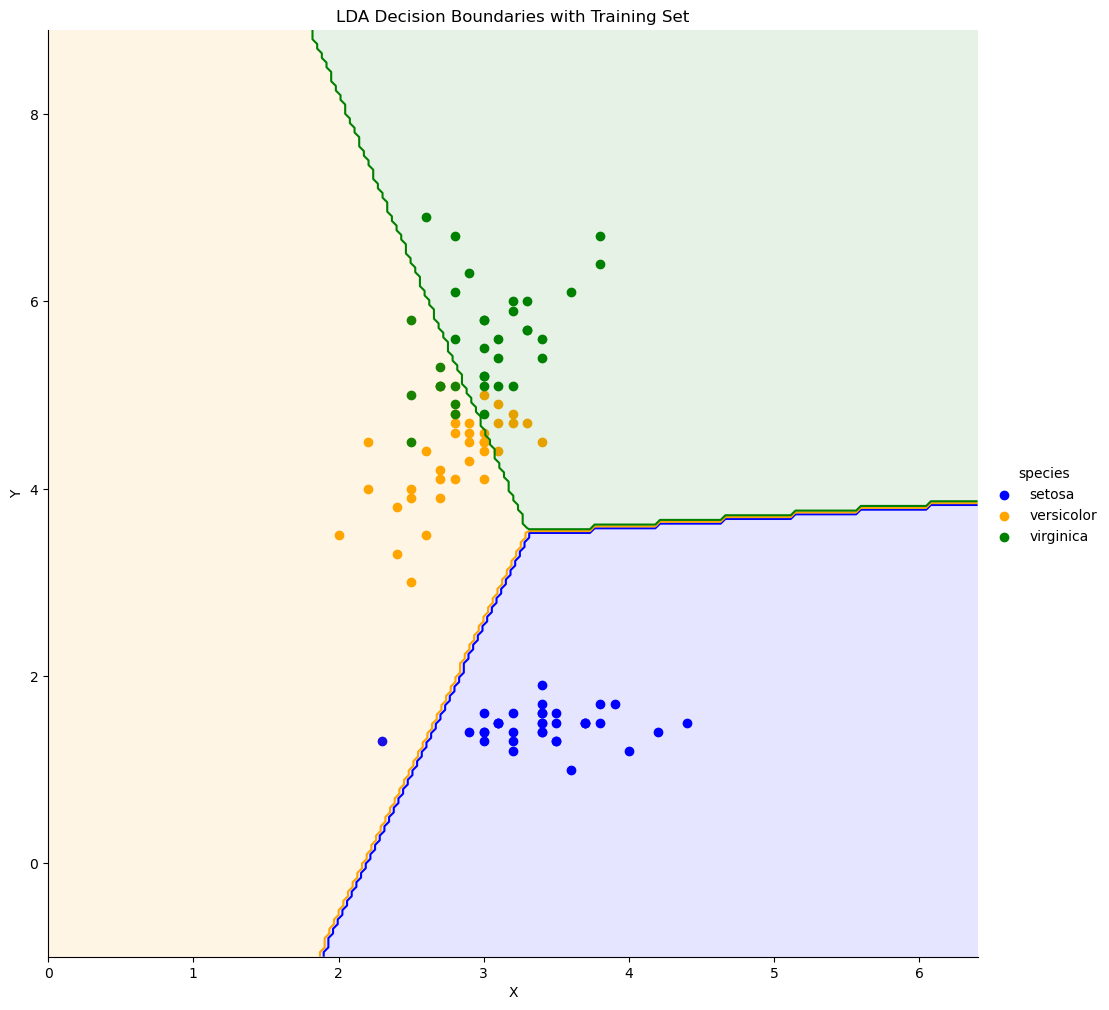

In [8]:
# Plot 
g = sns.FacetGrid(data, hue="species", height=10, palette=('blue','orange','green'))
g.map(plt.scatter, iris.feature_names[j], iris.feature_names[k])
g.add_legend()
my_ax = g.ax


#Computing the predicted class function for each value on the grid
zz = np.array(  [predict_LDA_class( np.array([xx,yy]).reshape(-1,1), mu_list, sigma, pi_list) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    
#Reshaping the predicted class into the meshgrid shape
Z = zz.reshape(X.shape)


#Plot the filled and boundary contours
my_ax.contourf( X, Y, Z, 2, alpha = .1, colors = ('blue','orange','green'))
my_ax.contour( X, Y, Z, 2, alpha = 1, colors = ('blue','orange','green'))

# Addd axis and title
my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('LDA Decision Boundaries with Training Set')

plt.show()



We should now evaluate the model. Rather than compute the confusion matrix as we have in examples 5A and 5B, let's look at the `classification_report` from Scikit-Learn. This contains all the relevant data we would want with respect to accuracy, precision, and recall in a nice chart. 

In [9]:
# Convert test labels to numbers
species_to_num = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
Y_test_numeric = np.array([species_to_num[species] for species in Y_test])

#Classify and compute test set
Y_pred = np.array([predict_LDA_class(np.array(row).reshape(-1, 1), mu_list, sigma, pi_list) 
                   for _, row in X_test.iloc[:, [j, k]].iterrows()])

print(classification_report(Y_test_numeric, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.74      0.93      0.82        15
           2       0.91      0.67      0.77        15

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.86        45
weighted avg       0.88      0.87      0.86        45



Testing set has 45 samples


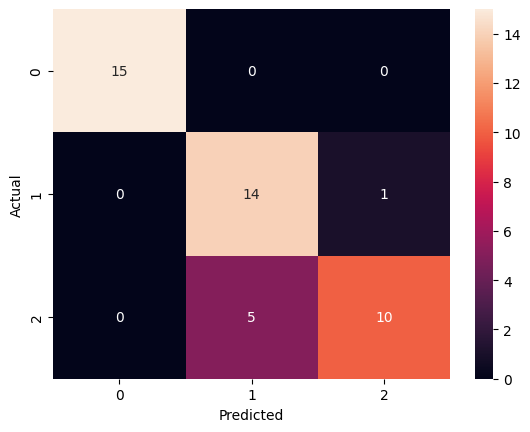

In [10]:
print(f"Testing set has {len(Y_test)} samples")

# Calculate confusion matrix
confusion_matrix = pd.crosstab(Y_test_numeric, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()


In [11]:
data_test.iloc[:, [j, k, 4]]


,sepal width (cm),petal length (cm),species
4,3.6,1.4,virginica
116,3.0,5.5,NaN
2,3.2,1.3,setosa
23,3.3,1.7,setosa
123,2.7,4.9,NaN
...,...,...,...
38,NaN,NaN,versicolor
40,NaN,NaN,setosa
41,NaN,NaN,virginica
42,NaN,NaN,versicolor
